In [1]:
import numpy as np
import pandas as pd
import seaborn as sn

from tensorflow import keras
from gensim.models.doc2vec import Doc2Vec
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from src.preprocessing import Preprocessor
from src.utils import read_data

In [6]:
doc2vec_model_embeddings = Doc2Vec.load(
    "models/best_doc2vec_embeddings")
doc2vec_model = keras.models.load_model(
    "models/best_doc2vec_model.h5")
tfidf_model = keras.models.load_model("models/best_tfidf_model.h5")

In [2]:
X_train, X_test, y_train, y_test = read_data()

In [10]:
preprocessor = Preprocessor()

### Best combination of TF-IDF model

In [11]:
first_party_names_3 = X_train["first_party"]
second_party_names_3 = X_train["second_party"]
facts_3 = X_train["Facts"]

In [12]:
test_first_party_names_3 = X_test["first_party"]
test_second_party_names_3 = X_test["second_party"]
test_facts_3 = X_test["Facts"]

In [13]:
anonymized_facts_3 = preprocessor.anonymize_data(
    first_party_names_3, second_party_names_3, facts_3)
test_anonymized_facts_3 = preprocessor.anonymize_data(
    test_first_party_names_3, test_second_party_names_3, test_facts_3)

In [14]:
text_vectorizer_3, X_train_vectors_3 = preprocessor.convert_text_to_vectors_tf_idf(
    anonymized_facts_3)

In [15]:
X_test_vectors_3 = preprocessor.convert_text_to_vectors_tf_idf(
    test_anonymized_facts_3, train=False, text_vectorizer=text_vectorizer_3)

In [16]:
y_preds_tfidf = tfidf_model.predict(X_test_vectors_3)

22/22 [==============================] - 1s 9ms/step


In [39]:
preds = np.where(y_preds_tfidf > 0.5, 1, 0)
accuracy = accuracy_score(y_test, preds)
print("TF-IDF accuracy: {:.3f}".format(accuracy))

TF-IDF accuracy: 0.973


### Best Combination of Doc2Vec  Model

In [40]:
X_test_processed = preprocessor.preprocess_data(X_test["Facts"])

In [41]:
X_test_vectors_doc2vec = preprocessor.convert_text_to_vectors_doc2vec(
    X_test_processed, train=False, embeddings_doc2vec=doc2vec_model_embeddings)

In [42]:
y_preds_doc2vec = doc2vec_model.predict(X_test_vectors_doc2vec)

22/22 [==============================] - 0s 2ms/step


In [46]:
preds_2 = np.where(y_preds_doc2vec > 0.5, 1, 0)
accuracy = accuracy_score(y_test, preds_2)
print("Doc2Vec accuracy: {:.3f}".format(accuracy))

Doc2Vec accuracy: 0.944


### Combining both accuracies

In [47]:
voting_predcitions = (y_preds_doc2vec + y_preds_tfidf) / 2
voting_predcitions = np.where(voting_predcitions > 0.5, 1, 0)
accuracy = accuracy_score(y_test, voting_predcitions)
print("Voting accuracy: {:.3f}".format(accuracy))

Voting accuracy: 0.986


<AxesSubplot:>

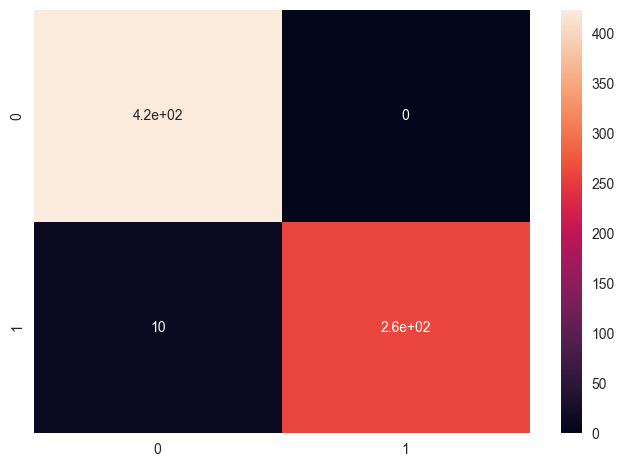

In [51]:
cf = confusion_matrix(y_test, voting_predcitions)
sn.heatmap(cf, annot=True)

In [54]:
cls_report = classification_report(y_test, voting_predcitions)
print(cls_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       423
           1       1.00      0.96      0.98       270

    accuracy                           0.99       693
   macro avg       0.99      0.98      0.98       693
weighted avg       0.99      0.99      0.99       693

